# BLEU and COMET Exploration and Basic Testing

BLEU and COMET are two machine translation evaluation metrics in use today, and in this project my goal is to understand their application and begin looking into the efficacy of popular LLMs in MT of Chinese to English.

[BLEU](http://www.aclweb.org/anthology/P02-1040.pdf) is one of the oldest machine translation evaluation metrics, but is still widely popular today. It operate

[COMET](https://arxiv.org/pdf/2009.09025) is a much newer evaluation metric, released in 2020, and uses machine learning to calculate scores.

In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from comet import download_model, load_from_checkpoint
import numpy as np

I will be using a set of CWMT data I found on Kaggle [here](https://www.kaggle.com/datasets/warmth/cwmt-data). 

The dataset contains a large quantity of information from several years of CWMT conferences (2008, 2009, 2011) as well as a number of other sources, though for the purposes of this exploration I will be limiting my observations to specificially Chinese -> English datasets.

In [66]:
#importing the datasets properly for manipulation
df2008 = pd.read_csv("mt-dataset/cwmt2008_ce_news.tsv", delimiter="\t")
df2009 = pd.read_csv("mt-dataset/cwmt2009_ce_news.tsv", delimiter="\t")

# # drops the 4 rows between the two datasets missing a third reference
# df2008.dropna()
# df2009.dropna()

df2008.head()

,datasource,domain,setid,srclang,trglang,src,ref1,ref2,ref3
0,cwmt2008,ce-news,zh_en_news_trans,zh,en,狭小的防震棚已经成为北川擂鼓镇农民张秀华（58岁）临时的家，而就在这个“家”的中央，悬挂了一...,A small narrow anti-earthquake tent became the...,The shockproof shed has become a temporary hom...,The narrow quakeproof shelter has become the t...
1,cwmt2008,ce-news,zh_en_news_trans,zh,en,画像中，中共中央总书记胡锦涛和国务院总理温家宝两人在绵阳机场紧紧握手，画像下有一行题字：“伟...,"In this portrait, Hu Jintao, the General Secre...",The picture showed General Secretary of the Co...,"Hu Jintao, the general secretary of the CPC Ce..."
2,cwmt2008,ce-news,zh_en_news_trans,zh,en,5月16日，四川汶川大地震发生后的第四天，胡锦涛从北京飞抵四川绵竹机场，亲自指挥抗震救灾。,"On May 16th, four days after the Wenchuan eart...","On May 16, the fourth day after the Wenchuan E...","On May 16, the 4th day following Sichuan Wench..."
3,cwmt2008,ce-news,zh_en_news_trans,zh,en,地震后当天就飞到灾区指挥的温家宝到机场迎接，两人一见面，就在飞机前握手致意。,"Wen Jiabao, who flew to the disaster area same...","Wen Jiabao, who has arrived at the disaster ar...","Wen Jiabao, who flew to the quake-hit areas an..."
4,cwmt2008,ce-news,zh_en_news_trans,zh,en,张秀华家挂的胡、温画像是经过电脑处理，原来画面的其他人员已经被掩盖，只有两个人握手的画面。,The portrait of Hu and Wen hung in Zhang Xiuhu...,The portrait of Hu and Wen hung in Zhang Xiuhu...,The figure of President Hu and Premier Wen hun...


The two datasets I will be using are now properly imported, note that each source Chinese code has not one but three "correct" English reference translations.

My goal with this project is to learn about the application of the BLEU and COMET MT evaluation metrics, and to do this I will be evaluating the two main LLMs I've been using for my [Classical Chinese machine translation interface](https://github.com/softly-undefined/classical-chinese-tool-v2) off of two baseline scores:

1. A translation completed by Google Translate, a commonly accepted machine translation tool used widely
2. An approved reference translation, calculating BLEU and COMET comparing ref1 as the MT-generated output to ref2 and ref3 as references (this may be up for change, I'm not the hugest fan of using a different amount of reference translations for this section compared to earlier ones)
3. Potentially Apple Translate, to compare it's efficacy as well, although that is also potentially up for change.

Using this [tutorial](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/) to learn about calculating BLEU scores.


COMET- calculates sentence-by-sentence, when looking corpus-wide it is simply an average of the sentence level scores.

In [67]:
#example code to reference
references = [[['this', 'is', 'a', 'test'], ['this', 'is', 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print(score)

1.0


# Test Before Generating Translations

Later on in this project I will be generating a large number of translations using the different models I have been testing, but I want to ensure that I properly understand how to use the evaluation metrics before spending the time/money creating the translations.

## BLEU Score Testing
First I will use BLEU to generate scores for the ref1 columns of the 2008 data compared to the ref2 and ref3 data

In [56]:
#extract the relevant data
df_test = df2008

# format references from ref2 and ref3 columns
df_test[['ref2', 'ref3']] = df_test[['ref2', 'ref3']].astype(str)
references_test = df_test[['ref2', 'ref3']].values.tolist()
references_test = [[sentence.split() for sentence in ref_group] for ref_group in references_test]

# format candidates from ref1 column
df_test['ref1'] = df_test['ref1'].astype(str)
candidates_test = df_test['ref1'].values.tolist()
candidates_test = [sentence.split() for sentence in candidates_test]

bleu_score = corpus_bleu(references_test, candidates_test)
print(bleu_score)

0.2520605875656664


I repeated the process using ref2 and ref3 as the candidates resulting in values of 0.2377663462841575 and 0.2208567008054941 respectively. These scores seem to make sense comparing them to numbers from the [original BLEU paper](https://aclanthology.org/P02-1040.pdf)



With the knowledge from the [original BLEU paper](https://aclanthology.org/P02-1040.pdf) it is clear that I should not compare BLEU scores based on different numbers of reference translations, so going forward I won't be using these translations to compare (though I may try testing my MT output on only 2 references to make it viable for comparison).

## COMET Score Testing

Next I will test the COMET Metric using the same idea of using the 2008 data and doing ref1 compared to ref2 and ref3

Rather than having to split up the sentences of reference and candidate word by word (which BLEU requires) COMET requires a specific format working with the sentences themselves.

In [5]:
#formatting the data correctly using ref1 as candidate and ref2 and ref4 as references
formatted_data = []

for _, row in df2008.iterrows():
    entry = {
        "src": row['src'],
        "mt": row['ref1'],
        "ref": [row['ref2'], row['ref3']]
    }
    formatted_data.append(entry)

In [28]:
model_path = download_model("Unbabel/wmt22-comet-da")

model = load_from_checkpoint(model_path)

model_output = model.predict(formatted_data, batch_size=8, gpus=0)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:58<00:00,  1.42s/it]


In [29]:
comet_score = sum(model_output.scores) / len(model_output.scores)
print(comet_score)

0.7343478642448517


Using ref2 as the candidate resulted in a comet_score of 0.7299891123122296, and ref3 a comet_score of 0.7139009555753609. It's interesting that both BLEU and COMET have a decreasing score order when using different references, probably just chance that it is decreasing but could show the correlation between BLEU and COMET scores.

# Translation Generation

I won't be generating the sentences themselves in this notebook file, but I have in separate files within this project, storing the resulting data in two .csv files.

In [68]:
translations2008 = pd.read_csv("mtranslations/translations2008.csv")
translations2009 = pd.read_csv("mtranslations/translations2009.csv")

# next here add each of the .csv's data to the df2008 and df2009 dataframes respectively

for col in translations2008.columns:
    df2008[col] = translations2008[col]
    
for col in translations2009.columns:
    df2009[col] = translations2009[col]

df2008.head(2)
    
    

,datasource,domain,setid,srclang,trglang,src,ref1,ref2,ref3,gpt-3.5-turbo,gpt-4o,claude-3-opus-20240229,gpt-4-turbo,googletrans,claude-3-haiku-20240307,claude-3-sonnet-20240229
0,cwmt2008,ce-news,zh_en_news_trans,zh,en,狭小的防震棚已经成为北川擂鼓镇农民张秀华（58岁）临时的家，而就在这个“家”的中央，悬挂了一...,A small narrow anti-earthquake tent became the...,The shockproof shed has become a temporary hom...,The narrow quakeproof shelter has become the t...,"In the small earthquake-resistant shed, which ...",The small earthquake-proof shelter has become ...,The cramped earthquake-resistant shelter has b...,The narrow earthquake shelter has become the t...,The narrow earthquake -proof shed has become a...,The narrow earthquake-proof shed has become th...,The small quake-proof shed has become a tempor...
1,cwmt2008,ce-news,zh_en_news_trans,zh,en,画像中，中共中央总书记胡锦涛和国务院总理温家宝两人在绵阳机场紧紧握手，画像下有一行题字：“伟...,"In this portrait, Hu Jintao, the General Secre...",The picture showed General Secretary of the Co...,"Hu Jintao, the general secretary of the CPC Ce...","In the image, the General Secretary of the Com...","In the picture, Hu Jintao, General Secretary o...","In the image, Hu Jintao, General Secretary of ...","In the image, Hu Jintao, General Secretary of ...","In the portrait, Hu Jintao, General Secretary ...","In the image, General Secretary of the CPC Cen...","The image shows Hu Jintao, the General Secreta..."


In [69]:
# the model names will be stored in this array for reference
# when calculating BLEU and COMET scores 
translation_models2008 = translations2008.columns.values
translation_models2009 = translations2009.columns.values

print(translation_models2009) #shows the column names

['gpt-3.5-turbo' 'gpt-4o' 'claude-3-opus-20240229' 'gpt-4-turbo'
 'googletrans' 'claude-3-haiku-20240307' 'claude-3-sonnet-20240229']


# BLEU Score Calculation

Now that we have the translations we are looking to evaluated in our dataframe, we can calculate the BLEU scores for each of our different translation methods 

## 2008 Dataset

In [70]:
#creating a references array for the 2008 dataset in a format acceptable to corpus_bleu
bleu_scores2008 = []

df2008[['ref1', 'ref2', 'ref3']] = df2008[['ref1', 'ref2', 'ref3']].astype(str)
references2008 = df2008[['ref1', 'ref2', 'ref3']].values.tolist()
references2008 = [[sentence.split() for sentence in ref_group] for ref_group in references2008]


for model in translation_models2008:
    df2008[model] = df2008[model].astype(str)
    candidates2008 = df2008[model].values.tolist()
    candidates2008 = [sentence.split() for sentence in candidates2008]
    
    bleu_score = corpus_bleu(references2008, candidates2008)
    
    bleu_scores2008.append((model, bleu_score))
    
for model, bleu_score in bleu_scores2008:
    print(f"{model} BLEU score (2008 Dataset): {bleu_score}")
    

gpt-3.5-turbo BLEU score (2008 Dataset): 0.36272498786487917
gpt-4o BLEU score (2008 Dataset): 0.34667685585819497
claude-3-opus-20240229 BLEU score (2008 Dataset): 0.32902219032536095
gpt-4-turbo BLEU score (2008 Dataset): 0.3531188082308687
googletrans BLEU score (2008 Dataset): 0.33226220541092993
claude-3-haiku-20240307 BLEU score (2008 Dataset): 0.34610817555657886
claude-3-sonnet-20240229 BLEU score (2008 Dataset): 0.33404968625832887


## 2009 Dataset

In [71]:
#creating a references array for the 2009 dataset in a format acceptable to corpus_bleu
bleu_scores2009 = []

df2009[['ref1','ref2','ref3']] = df2009[['ref1','ref2','ref3']].astype(str)
references2009 = df2009[['ref1','ref2','ref3']].values.tolist()
references2009 = [[sentence.split() for sentence in ref_group] for ref_group in references2009]


for model in translation_models2009:
    df2009[model] = df2009[model].astype(str)
    candidates2009 = df2009[model].values.tolist()
    candidates2009 = [sentence.split() for sentence in candidates2009]
    
    bleu_score = corpus_bleu(references2009, candidates2009)
    
    bleu_scores2009.append((model, bleu_score))
    
    
for model, bleu_score in bleu_scores2009:
    print(f"{model} BLEU score (2009 Dataset): {bleu_score}")
    

gpt-3.5-turbo BLEU score (2008 Dataset): 0.30913239644904833
gpt-4o BLEU score (2008 Dataset): 0.2900060381857527
claude-3-opus-20240229 BLEU score (2008 Dataset): 0.2657435187628175
gpt-4-turbo BLEU score (2008 Dataset): 0.30053329239295573
googletrans BLEU score (2008 Dataset): 0.2972482890848131
claude-3-haiku-20240307 BLEU score (2008 Dataset): 0.2918647574160884
claude-3-sonnet-20240229 BLEU score (2008 Dataset): 0.2741057490875309


## BLEU Visualization

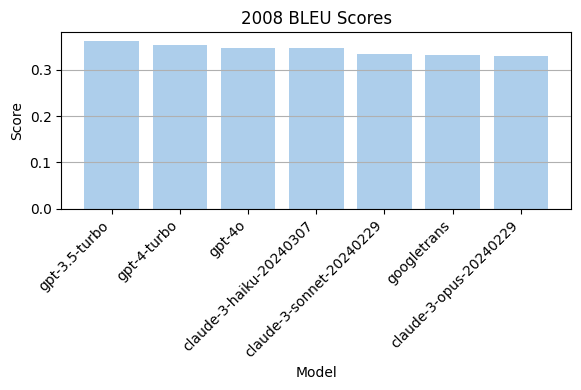

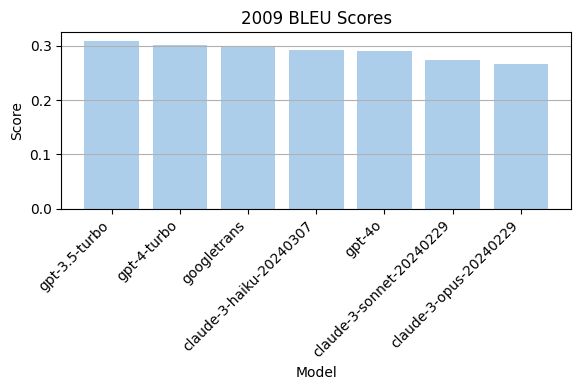

In [72]:
vis_df2008 = pd.DataFrame(bleu_scores2008, columns=['name', 'score'])
vis_df2008 = vis_df2008.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2008['name'], vis_df2008['score'], color='#ADCEEB')
plt.title('2008 BLEU Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

vis_df2009 = pd.DataFrame(bleu_scores2009, columns=['name', 'score'])
vis_df2009 = vis_df2009.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2009['name'], vis_df2009['score'], color='#ADCEEB')
plt.title('2009 BLEU Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# COMET Score Calculation

Finally, we will calculate the COMET evaluation metrics.

## 2008 Dataset

In [73]:
comet_scores2008 = []


for model_name in translation_models2008:    
    formatted_data2008 = []
    
    for _, row in df2008.iterrows():
        entry = {
            "src": row['src'],
            "mt": row[model_name],
            "ref": [row['ref1'],row['ref2'], row['ref3']]
        }
        formatted_data2008.append(entry)

    model_path = download_model("Unbabel/wmt22-comet-da")
    model = load_from_checkpoint(model_path)
    model_output = model.predict(formatted_data2008, batch_size=8, gpus=0)
    
    comet_score = sum(model_output.scores) / len(model_output.scores)
    
    comet_scores2008.append((model_name, comet_score))
    

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:31<00:00,  1.68s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:18<00:00,  1.58s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:33<00:00,  1.69s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:15<00:00,  1.55s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:06<00:00,  1.48s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:20<00:00,  1.59s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:18<00:00,  1.58s/it]


In [75]:
for model, comet_score in comet_scores2008:
    print(f"{model} COMET score (2008 Dataset): {comet_score}")

gpt-3.5-turbo COMET score (2008 Dataset): 0.7149052590605753
gpt-4o COMET score (2008 Dataset): 0.718907313750942
claude-3-opus-20240229 COMET score (2008 Dataset): 0.7118654007288381
gpt-4-turbo COMET score (2008 Dataset): 0.7162852217082238
googletrans COMET score (2008 Dataset): 0.650298691945332
claude-3-haiku-20240307 COMET score (2008 Dataset): 0.7106362168582723
claude-3-sonnet-20240229 COMET score (2008 Dataset): 0.69838161493983


## 2009 Dataset

In [76]:
comet_scores2009 = []

for model_name in translation_models2009:
    formatted_data2009 = []
    
    for _, row in df2009.iterrows():
        entry = {
            "src": row['src'],
            "mt": row[model_name],
            "ref": [row['ref1'],row['ref2'], row['ref3']]
        }
        formatted_data2009.append(entry) 
    
    model_path = download_model("Unbabel/wmt22-comet-da")
    model = load_from_checkpoint(model_path)
    model_output = model.predict(formatted_data2009, batch_size=8, gpus=0)
    
    
    comet_score = sum(model_output.scores) / len(model_output.scores)
    
    comet_scores2009.append((model_name, comet_score))
    

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:17<00:00,  1.57s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:10<00:00,  1.52s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:24<00:00,  1.62s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:02<00:00,  1.45s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:01<00:00,  1.44s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:17<00:00,  1.57s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [03:15<00:00,  1.55s/it]


In [77]:
for model_name, comet_score in comet_scores2009:
    print(f"{model_name} COMET score (2009 Dataset): {comet_score}")

gpt-3.5-turbo COMET score (2009 Dataset): 0.7005166230149426
gpt-4o COMET score (2009 Dataset): 0.7044945020796889
claude-3-opus-20240229 COMET score (2009 Dataset): 0.6998935246158573
gpt-4-turbo COMET score (2009 Dataset): 0.6998721400678811
googletrans COMET score (2009 Dataset): 0.6318985382141407
claude-3-haiku-20240307 COMET score (2009 Dataset): 0.696696911887419
claude-3-sonnet-20240229 COMET score (2009 Dataset): 0.6842840679383587


## COMET Visualization

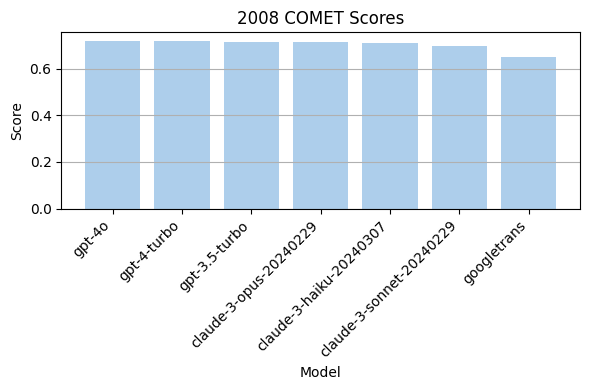

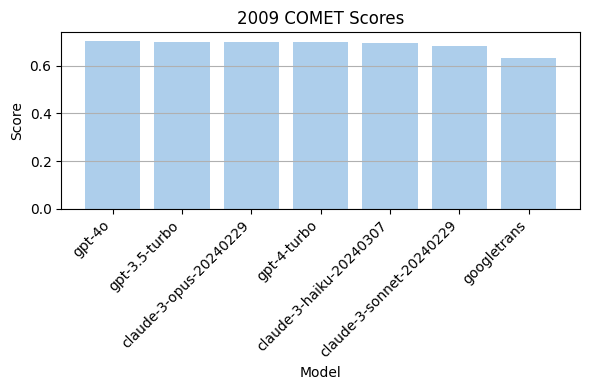

In [78]:
vis_df2008 = pd.DataFrame(comet_scores2008, columns=['name', 'score'])
vis_df2008 = vis_df2008.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2008['name'], vis_df2008['score'], color='#ADCEEB')
plt.title('2008 COMET Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

vis_df2009 = pd.DataFrame(comet_scores2009, columns=['name', 'score'])
vis_df2009 = vis_df2009.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2009['name'], vis_df2009['score'], color='#ADCEEB')
plt.title('2009 COMET Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
vis_df2008.head()

,name,score
2,gpt-4o,0.718907
5,gpt-4-turbo,0.716285
0,gpt-3.5-turbo,0.714905
3,claude-3-opus-20240229,0.711865
1,claude-3-haiku-20240307,0.710958


# BASELINE TESTING

While the above testing is great for comparing the different models, I'm very interested in having access to a baseline which is deemed 100% correct. To test this I will be using ref1 from both datasets as another candidate translation, with ref2 and ref3 serving as the sole references for BLEU and COMET scoring.

## BLEU Scores

2008 Dataset BLEU Scores: 

gpt-3.5-turbo BLEU score (2008 Dataset): 0.2376184999384555
claude-3-haiku-20240307 BLEU score (2008 Dataset): 0.2376184999384555
gpt-4o BLEU score (2008 Dataset): 0.2376184999384555
claude-3-opus-20240229 BLEU score (2008 Dataset): 0.2376184999384555
claude-3-sonnet-20240229 BLEU score (2008 Dataset): 0.2376184999384555
gpt-4-turbo BLEU score (2008 Dataset): 0.2376184999384555
ref1 BLEU score (2008 Dataset): 0.2376184999384555

2009 Dataset BLEU Scores: 

gpt-3.5-turbo BLEU score (2009 Dataset): 0.2376184999384555
claude-3-haiku-20240307 BLEU score (2009 Dataset): 0.2376184999384555
gpt-4o BLEU score (2009 Dataset): 0.2376184999384555
claude-3-opus-20240229 BLEU score (2009 Dataset): 0.2376184999384555
claude-3-sonnet-20240229 BLEU score (2009 Dataset): 0.2376184999384555
gpt-4-turbo BLEU score (2009 Dataset): 0.2376184999384555
ref1 BLEU score (2009 Dataset): 0.2376184999384555


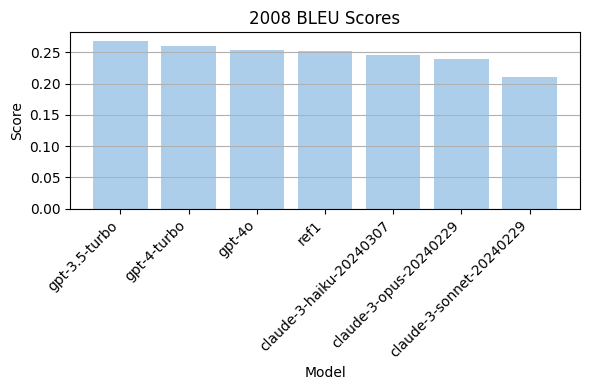

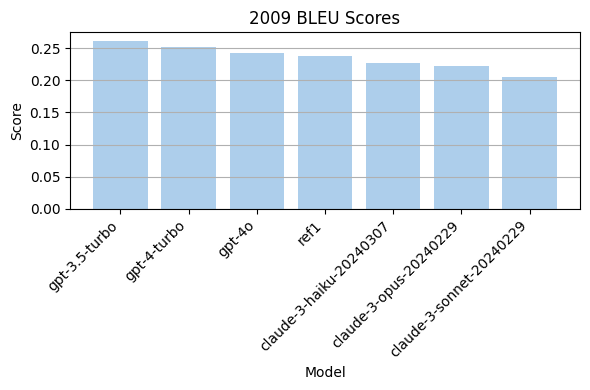

In [43]:
#adding ref1 to our translation models list so it is also calculated

baseline_translation_models2008 = translation_models2008
baseline_translation_models2008 = np.append(baseline_translation_models2008,'ref1')

baseline_translation_models2009 = translation_models2009
baseline_translation_models2009 = np.append(baseline_translation_models2009,'ref1')

baseline_bleu_scores2008 = []

df2008[['ref2', 'ref3']] = df2008[['ref2', 'ref3']].astype(str)
references2008 = df2008[['ref2', 'ref3']].values.tolist()
references2008 = [[sentence.split() for sentence in ref_group] for ref_group in references2008]


for model in baseline_translation_models2008:
    df2008[model] = df2008[model].astype(str)
    candidates2008 = df2008[model].values.tolist()
    candidates2008 = [sentence.split() for sentence in candidates2008]
    
    bleu_score = corpus_bleu(references2008, candidates2008)
    baseline_bleu_scores2008.append((model, bleu_score))
    
    
    
    
baseline_bleu_scores2009 = []

df2009[['ref2','ref3']] = df2009[['ref2','ref3']].astype(str)
references2009 = df2009[['ref2','ref3']].values.tolist()
references2009 = [[sentence.split() for sentence in ref_group] for ref_group in references2009]


for model in baseline_translation_models2009:
    df2009[model] = df2009[model].astype(str)
    candidates2009 = df2009[model].values.tolist()
    candidates2009 = [sentence.split() for sentence in candidates2009]
    
    bleu_score = corpus_bleu(references2009, candidates2009)
    baseline_bleu_scores2009.append((model, bleu_score))


print("2008 Dataset BLEU Scores: \n")
for model, name in baseline_bleu_scores2008:
    print(f"{model} BLEU score (2008 Dataset): {bleu_score}")

print("\n2009 Dataset BLEU Scores: \n")  
for model, name in baseline_bleu_scores2009:
    print(f"{model} BLEU score (2009 Dataset): {bleu_score}")

    
vis_df2008 = pd.DataFrame(baseline_bleu_scores2008, columns=['name', 'score'])
vis_df2008 = vis_df2008.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2008['name'], vis_df2008['score'], color='#ADCEEB')
plt.title('2008 BLEU Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

vis_df2009 = pd.DataFrame(baseline_bleu_scores2009, columns=['name', 'score'])
vis_df2009 = vis_df2009.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2009['name'], vis_df2009['score'], color='#ADCEEB')
plt.title('2009 BLEU Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## COMET Scores

In [79]:
baseline_comet_scores2008 = []


for model_name in baseline_translation_models2008:    
    formatted_data2008 = []
    
    for _, row in df2008.iterrows():
        entry = {
            "src": row['src'],
            "mt": row[model_name],
            "ref": [row['ref2'],row['ref3']]
        }
        formatted_data2008.append(entry)

    model_path = download_model("Unbabel/wmt22-comet-da")
    model = load_from_checkpoint(model_path)
    model_output = model.predict(formatted_data2008, batch_size=8, gpus=0)
    
    comet_score = sum(model_output.scores) / len(model_output.scores)
    
    baseline_comet_scores2008.append((model_name, comet_score))
    
    
baseline_comet_scores2009 = []

for model_name in baseline_translation_models2009:
    formatted_data2009 = []
    
    for _, row in df2009.iterrows():
        entry = {
            "src": row['src'],
            "mt": row[model_name],
            "ref": [row['ref2'],row['ref3']]
        }
        formatted_data2009.append(entry) 
    
    model_path = download_model("Unbabel/wmt22-comet-da")
    model = load_from_checkpoint(model_path)
    model_output = model.predict(formatted_data2009, batch_size=8, gpus=0)
    
    
    comet_score = sum(model_output.scores) / len(model_output.scores)
    
    baseline_comet_scores2009.append((model_name, comet_score))
    
    

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:25<00:00,  1.16s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:38<00:00,  1.26s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:40<00:00,  1.27s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:58<00:00,  1.42s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:46<00:00,  1.32s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:41<00:00,  1.29s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:33<00:00,  1.22s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:24<00:00,  1.15s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:25<00:00,  1.16s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:27<00:00,  1.17s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:49<00:00,  1.34s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:37<00:00,  1.25s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:31<00:00,  1.20s/it]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ericbennett/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|████████████████| 126/126 [02:38<00:00,  1.26s/it]


2008 Dataset COMET Scores: 

gpt-3.5-turbo COMET score (2008 Dataset): 0.7520782258176424
claude-3-haiku-20240307 COMET score (2008 Dataset): 0.7476331140127618
gpt-4o COMET score (2008 Dataset): 0.7553135688985081
claude-3-opus-20240229 COMET score (2008 Dataset): 0.7471011545264697
claude-3-sonnet-20240229 COMET score (2008 Dataset): 0.7356123123503111
gpt-4-turbo COMET score (2008 Dataset): 0.7534082885942687
ref1 COMET score (2008 Dataset): 0.7343478642448517

2009 Dataset COMET Scores: 

gpt-3.5-turbo COMET score (2008 Dataset): 0.7417234088166998
claude-3-haiku-20240307 COMET score (2008 Dataset): 0.7378558186388919
gpt-4o COMET score (2008 Dataset): 0.7462801242457073
claude-3-opus-20240229 COMET score (2008 Dataset): 0.7392663576845395
claude-3-sonnet-20240229 COMET score (2008 Dataset): 0.725663212277478
gpt-4-turbo COMET score (2008 Dataset): 0.7421474191151255
ref1 COMET score (2008 Dataset): 0.7193351247731377


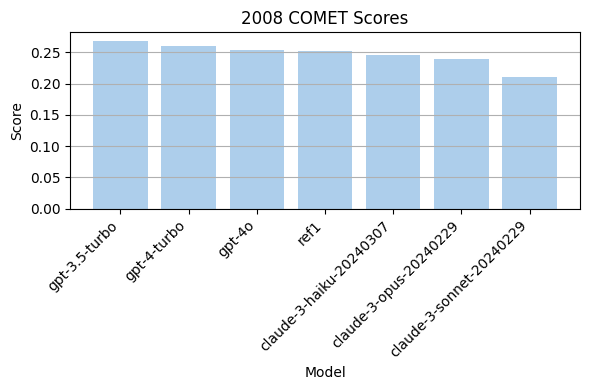

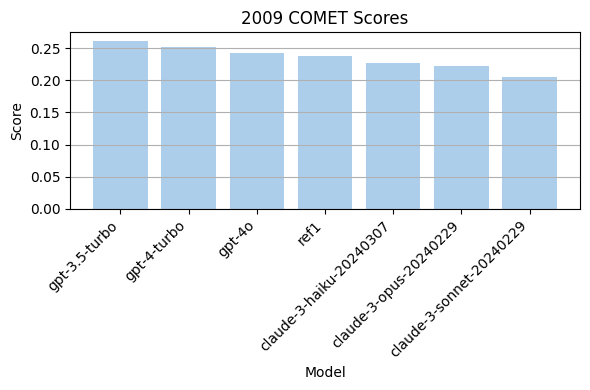

In [80]:
print("2008 Dataset COMET Scores: \n")
for model, comet_score in baseline_comet_scores2008:
    print(f"{model} COMET score (2008 Dataset): {comet_score}")
    
print("\n2009 Dataset COMET Scores: \n")
for model, comet_score in baseline_comet_scores2009:
    print(f"{model} COMET score (2008 Dataset): {comet_score}")

vis_df2008 = pd.DataFrame(baseline_bleu_scores2008, columns=['name', 'score'])
vis_df2008 = vis_df2008.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2008['name'], vis_df2008['score'], color='#ADCEEB')
plt.title('2008 COMET Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

vis_df2009 = pd.DataFrame(baseline_bleu_scores2009, columns=['name', 'score'])
vis_df2009 = vis_df2009.sort_values(by='score', ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(vis_df2009['name'], vis_df2009['score'], color='#ADCEEB')
plt.title('2009 COMET Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Very interesting how the reference is evaluated as the lowest COMET score compared to the lowest qualities of LLM based machine translation, 